In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import verify_gradients as vg
import visualize_clf as vclf
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree
from SoftSVM import SoftSVM
import verify_gradients as vg

import seaborn as sns

## Preliminary: Data Loading

In [3]:
def load_data(filename) -> np.ndarray:
    with open(f'data/{filename}') as file:
        data = pd.read_csv(file, index_col=0)
        return data

train = load_data('train_prepared.csv')
test = load_data('test_prepared.csv')

# TODO: Make sure we don't need to add the blood_type column

## Part 1: Basic model selection with kNN

### Visualization and basic analysis (Q1)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


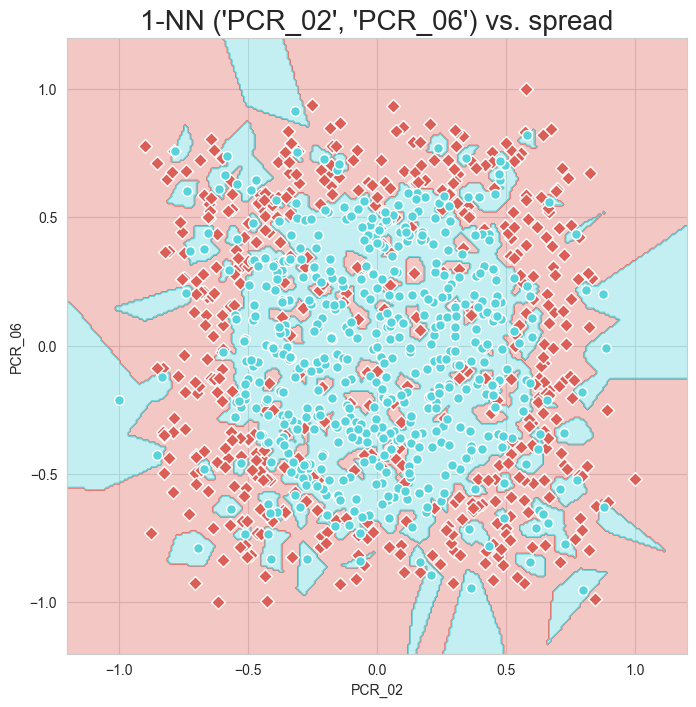

train score: 1.0
test score:  0.648


In [3]:
p1_feats = ('PCR_02', 'PCR_06')

p1_train = train[list(p1_feats)]
p1_test = test[list(p1_feats)]

# learn the training data
decision_tree = kNN(n_neighbors= 1, metric='euclidean')
decision_tree.fit(p1_train, train['spread'])

vclf.visualize_clf(decision_tree, p1_train, train['spread'], f'1-NN {p1_feats} vs. spread', *p1_feats)

print(f"train score: {decision_tree.score(p1_train, train['spread'])}")
print(f"test score:  {decision_tree.score(p1_test, test['spread'])}")

### Model selection

#### (Q2)

In [4]:
ks = list(range(1, 20, 2)) + list(range(20, 695, 65))
results = dict()

for k in ks:
    scores = cross_validate(kNN(k), p1_train, train['spread'], cv=8, return_train_score=True)
    results[k] = {
        'valid_mean': np.mean(scores['test_score']),
        'valid_std': np.std(scores['test_score']),
        'train_mean': np.mean(scores['train_score']),
        'train_std': np.std(scores['train_score'])
    }

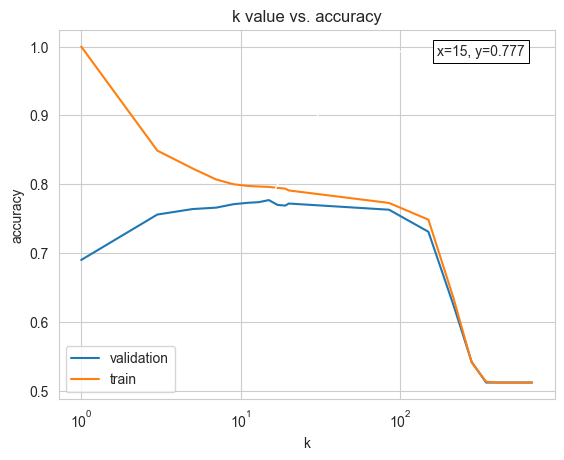

In [5]:
# plot and find best k

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    return xmax

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(ks, [results[k]['valid_mean'] for k in ks], label='validation')
ax.semilogx(ks, [results[k]['train_mean'] for k in ks], label='train')
ax.legend()
ax.grid(True)
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.set_title('k value vs. accuracy')

best_k = annot_max(ks, np.array([results[k]['valid_mean'] for k in ks]))
plt.show()

#### (Q3)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


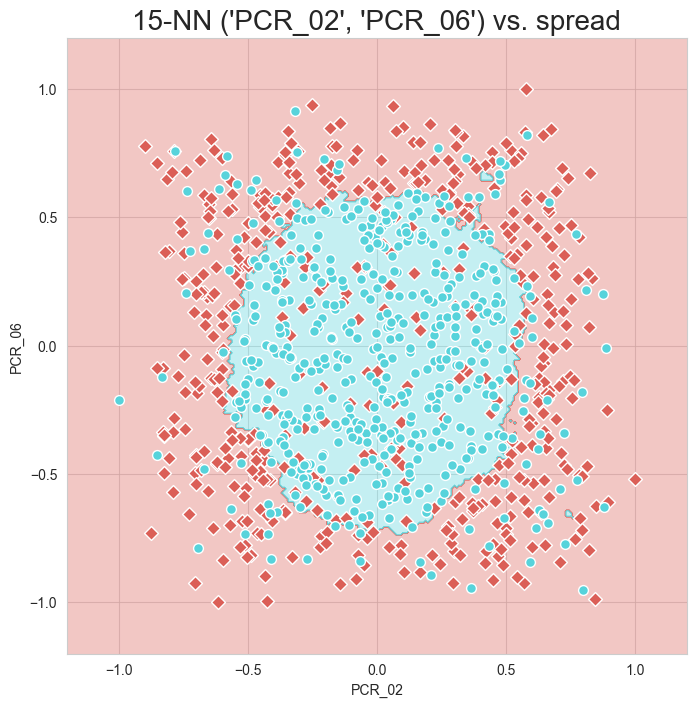

train accuracy: 0.798
test accuracy:  0.732


In [6]:
# learn the training data
decision_tree = kNN(n_neighbors=best_k, metric='euclidean')
decision_tree.fit(p1_train, train['spread'])

vclf.visualize_clf(decision_tree, p1_train, train['spread'], f'{best_k}-NN {p1_feats} vs. spread', *p1_feats)

print(f"train accuracy: {decision_tree.score(p1_train, train['spread'])}")
print(f"test accuracy:  {decision_tree.score(p1_test, test['spread'])}")

#### (Q4) - in docs

## Part 2: Decision trees

### Visualization

#### (Q5)

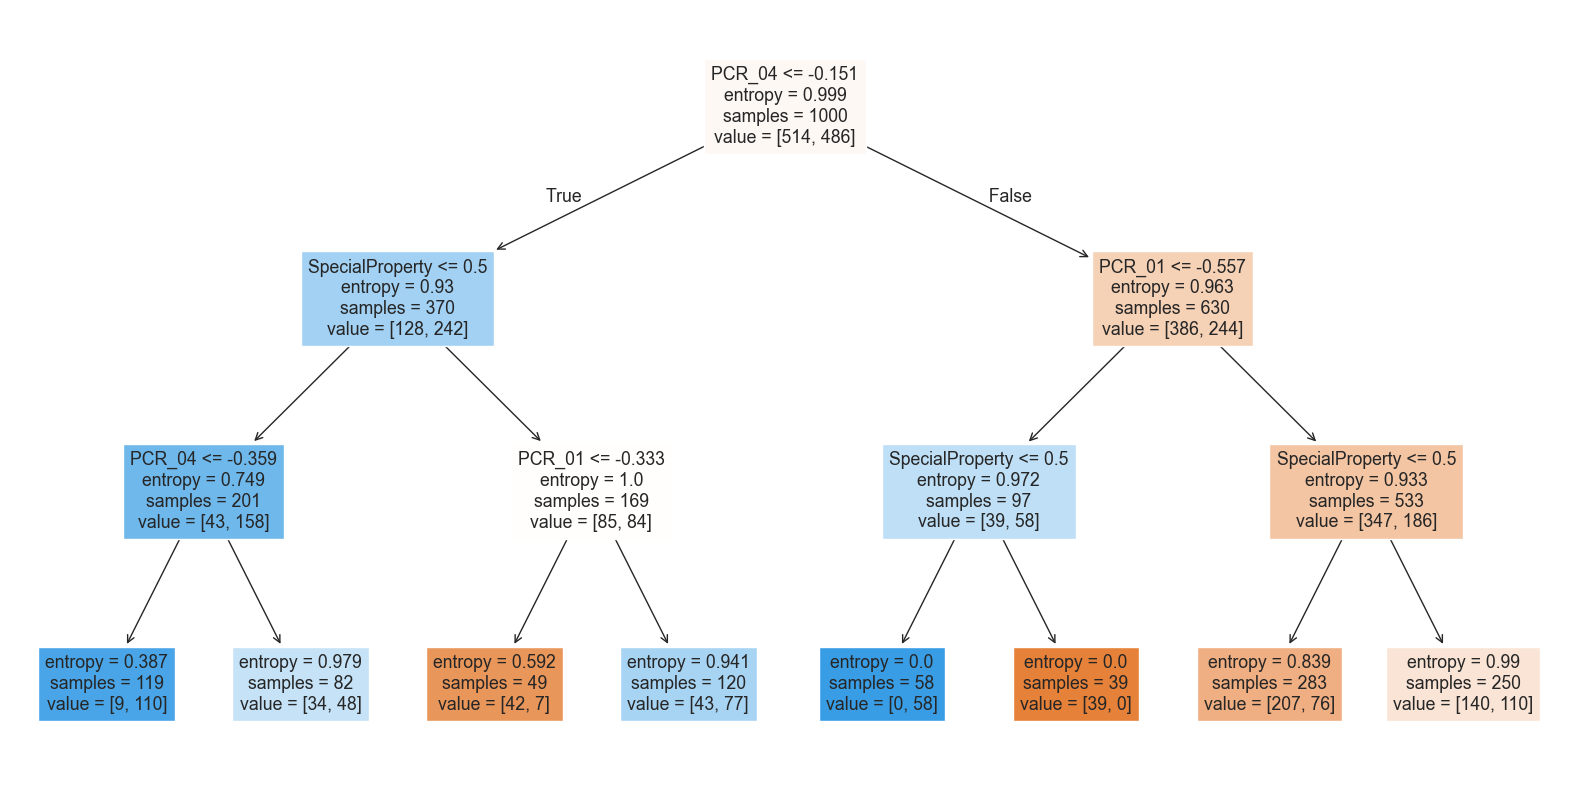

train accuracy: 0.721
test accuracy: 0.684


In [17]:
p2_feats = ('PCR_01', 'PCR_04', 'SpecialProperty')

p2_train = train[list(p2_feats)]
p2_test = test[list(p2_feats)]

# learn the training data
decision_tree = DT(criterion='entropy', max_depth=3)
decision_tree.fit(p2_train, train['risk'])

plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=p2_feats, max_depth=3, filled=True)
plt.show()

print(f"train accuracy: {decision_tree.score(p2_train, train['risk'])}")
print(f"test accuracy: {decision_tree.score(p2_test, test['risk'])}")

### Model selection

#### (Q6)

In [8]:
# learn the training data
min_samples_leaf_range = range(1, 26, 1)
max_depth_range = range(1, 26, 1)

hyperparameters = {
    'max_depth': max_depth_range,
    'min_samples_leaf': min_samples_leaf_range,
    'criterion': ['entropy']
}

grid_search = GridSearchCV(
    DT(),
    scoring='accuracy',
    param_grid=hyperparameters,
    return_train_score=True,
    cv=5
)
grid_search.fit(p2_train, train['risk'])
res = pd.DataFrame(grid_search.cv_results_)

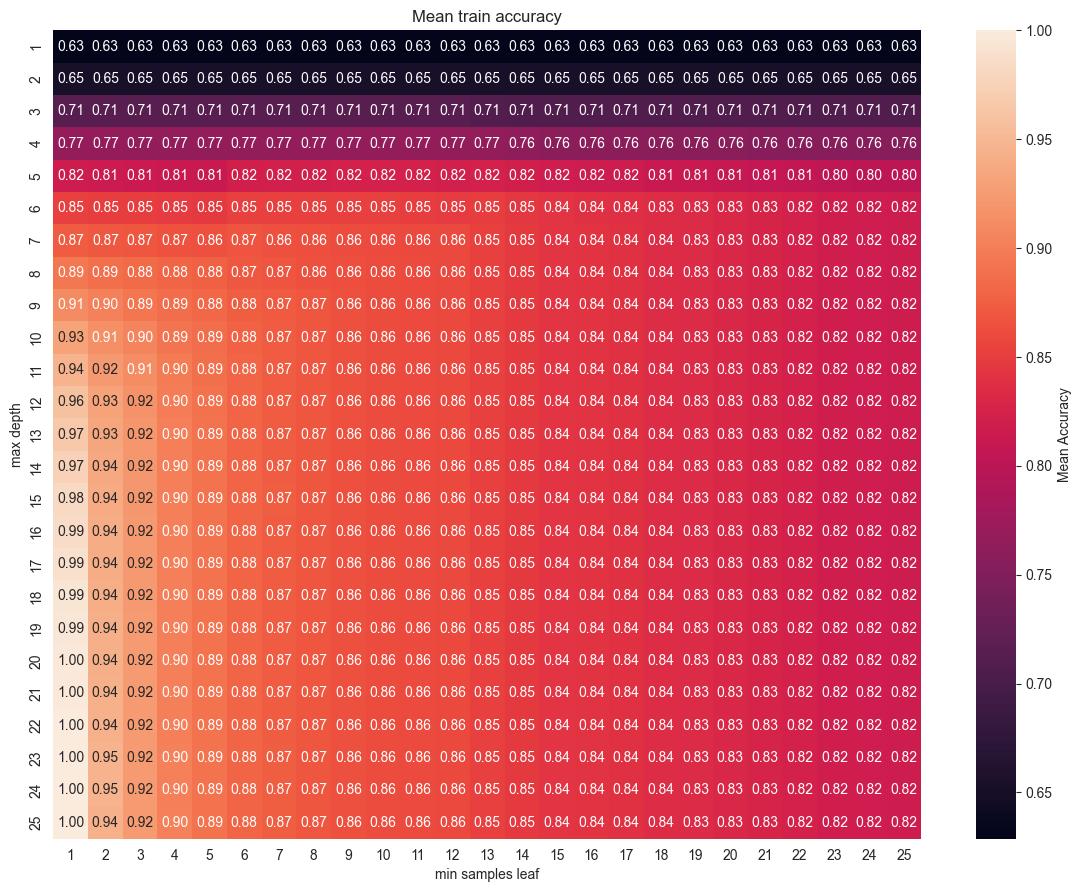

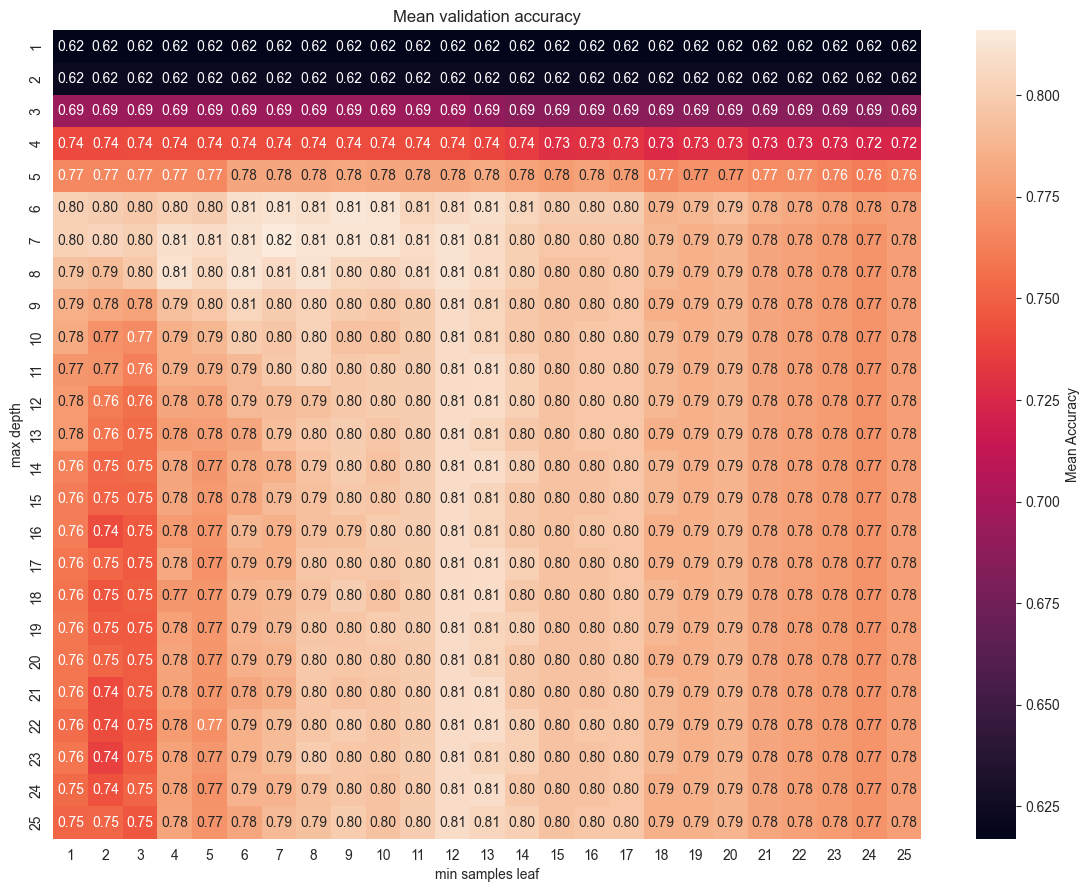

In [9]:
# Train heatmap
heatmap_data_train = res.pivot(
    index='param_max_depth',
    columns='param_min_samples_leaf',
    values='mean_train_score'
)

plt.figure(figsize=(14, 10.5))
sns.heatmap(heatmap_data_train, annot=True, fmt=".2f", cbar_kws={'label': 'Mean Accuracy'})
plt.title("Mean train accuracy")
plt.xlabel("min samples leaf")
plt.ylabel("max depth")
plt.show()


# Validation heatmap
heatmap_data_validation = res.pivot(
    index='param_max_depth',
    columns='param_min_samples_leaf',
    values='mean_test_score'
)

plt.figure(figsize=(14, 10.5))
sns.heatmap(heatmap_data_validation, annot=True, fmt=".2f", cbar_kws={'label': 'Mean Accuracy'})
plt.title("Mean validation accuracy")
plt.xlabel("min samples leaf")
plt.ylabel("max depth")
plt.show()

#### (Q7) - docs

#### (Q8)

In [10]:
max_depth_opt = 7
min_samples_leaf_opt = 7

# learn the training data
decision_tree = DT(criterion='entropy', max_depth=max_depth_opt, min_samples_leaf=min_samples_leaf_opt)
decision_tree.fit(p2_train, train['risk'])

print(f"train accuracy: {decision_tree.score(p2_train, train['risk'])}")
print(f"test accuracy: {decision_tree.score(p2_test, test['risk'])}")

train accuracy: 0.868
test accuracy: 0.828


## Part 3: Linear SVM and the Polynomial kernel

### Implementation of the loss and its gradient

#### (Q9)

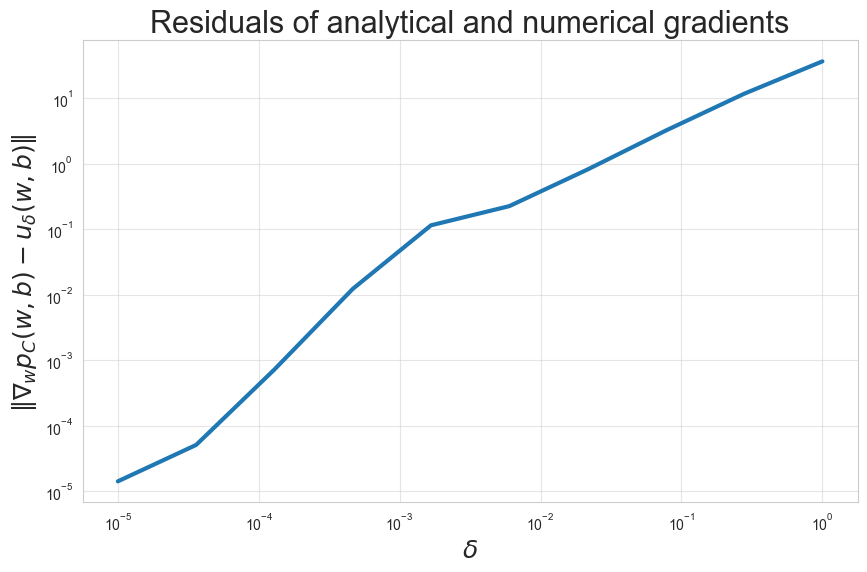

In [18]:
p3_feats = ('PCR_02', 'PCR_06')
p3_target = 'spread'

p3_train = train[list(p3_feats)]
p3_test = test[list(p3_feats)]

vg.compare_gradients(p3_train.to_numpy(), train[p3_target].to_numpy(), deltas=np.logspace(-5, 0, 10), REPEATS=100)

### Solving Soft SVM problems using Stochastic Gradient Descent (SGD)

#### (Q10) - docs

#### Task - pre Q11

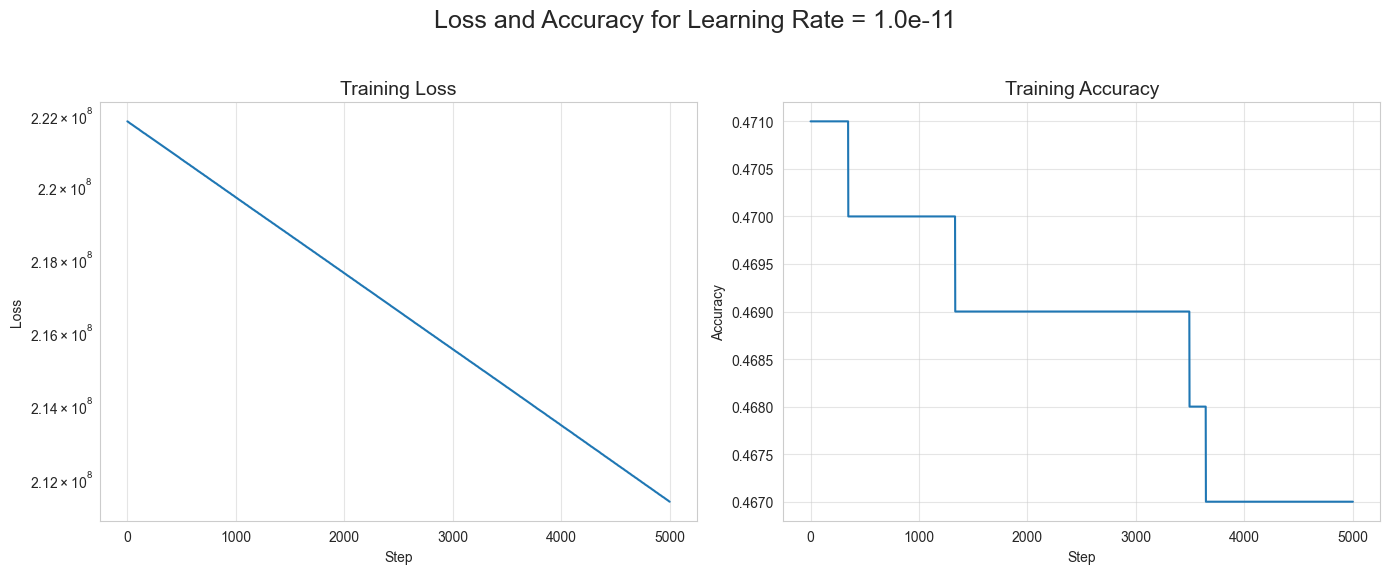

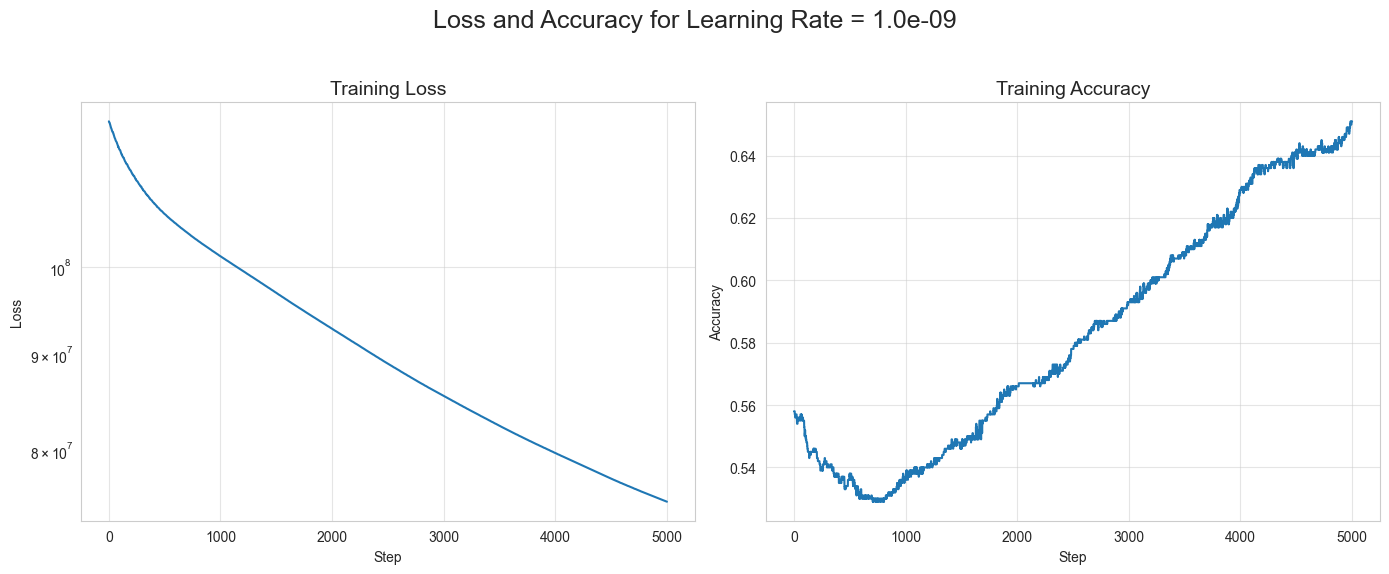

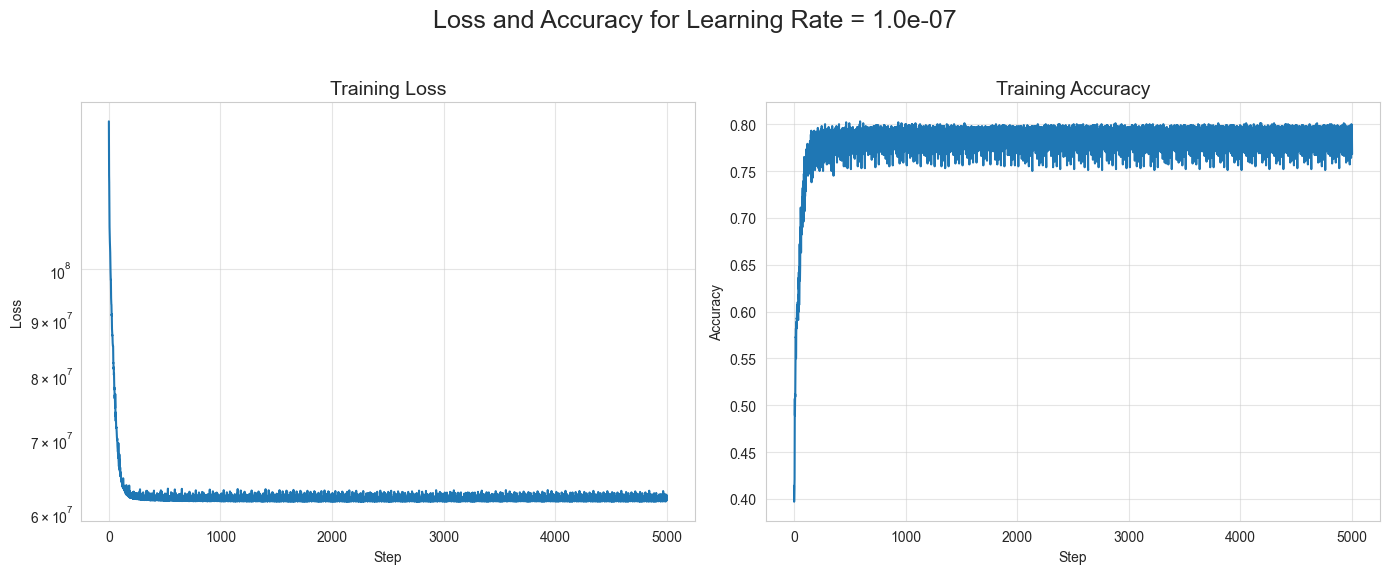

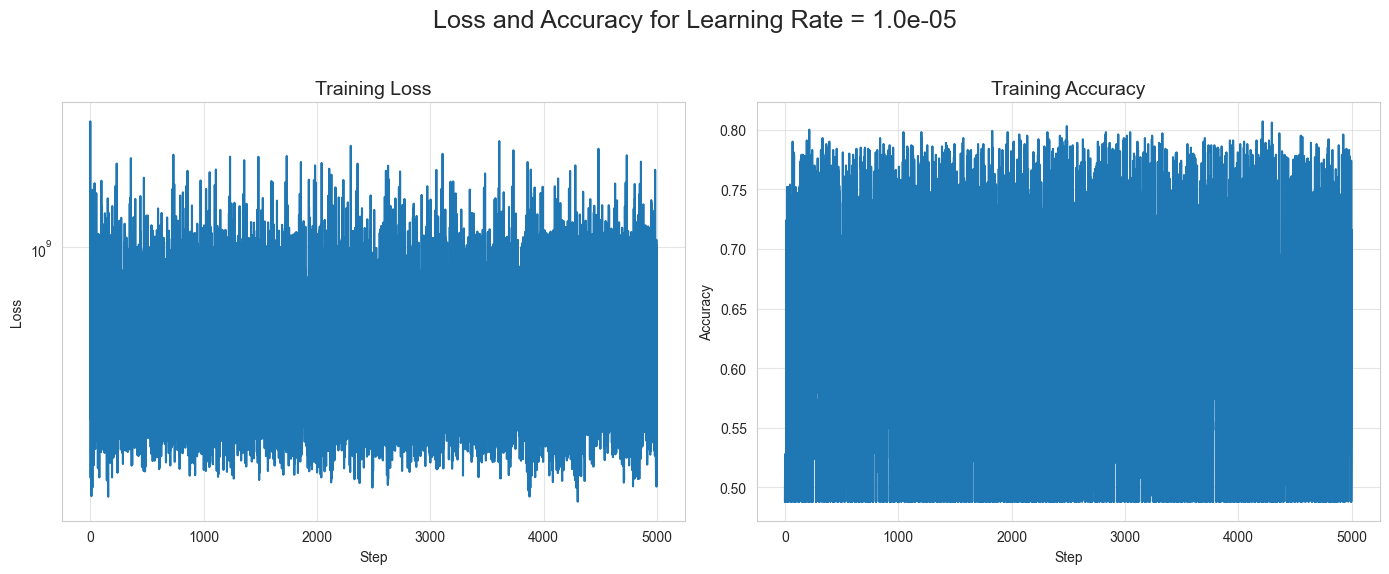

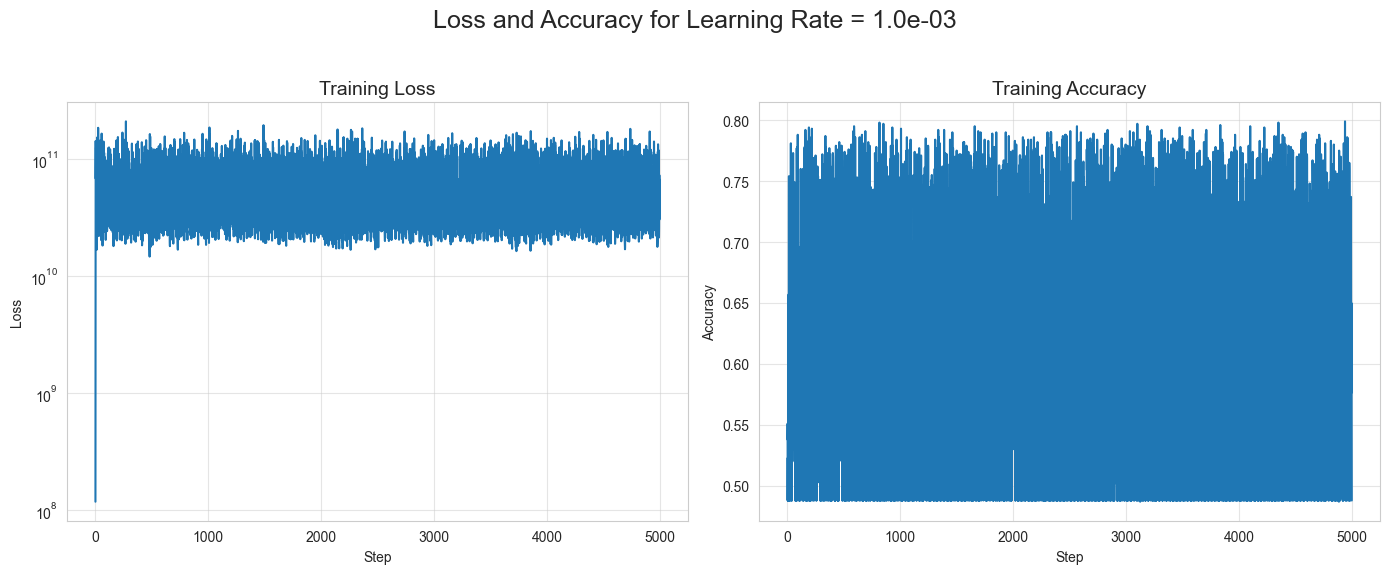

In [12]:
C = 1e5

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

X_train_poly = PolynomialFeatures(degree=3,).fit_transform(p3_train)
X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)

for lr in np.logspace(-11, -3, 5):
    clf = SoftSVM(C=C, lr=lr)
    X_train_poly = PolynomialFeatures(degree=3,).fit_transform(p3_train)
    X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
    losses, accuracies = clf.fit_with_logs(X_train_poly, train[p3_target].to_numpy(), max_iter=5000)

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Subplots with shared layout
    fig.suptitle(f'Loss and Accuracy for Learning Rate = {lr:.1e}', fontsize=18)

    # Loss plot
    axs[0].semilogy(losses)
    axs[0].set_title("Training Loss", fontsize=14)
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].grid(alpha=0.5)

    # Accuracy plot
    axs[1].plot(accuracies)
    axs[1].set_title("Training Accuracy", fontsize=14)
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(alpha=0.5)

    # Adjust layout
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### (Q12)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


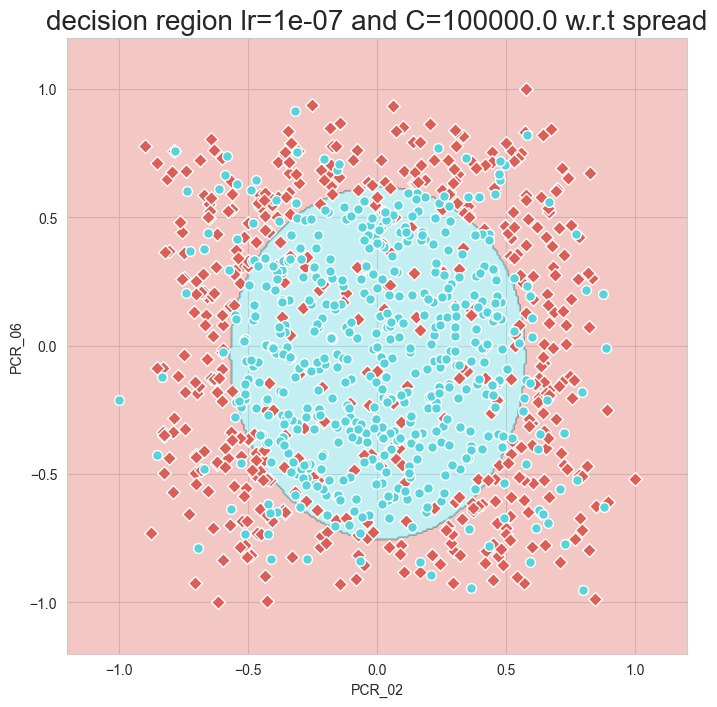

train accuracy: 0.799
test accuracy: 0.736


C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

best_lr = 1e-7
C = 1e5

svm_clf = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=3,)),
    ('scaler', MinMaxScaler()),
    ('SVM', SoftSVM(C=C, lr=best_lr))
])

svm_clf.fit(p3_train, train[p3_target].to_numpy())


vclf.visualize_clf(svm_clf, p3_train, train[p3_target], f'decision region lr={best_lr} and C={C} w.r.t {p3_target}', *p3_train)

print(f'train accuracy: {svm_clf.score(p3_train, train[p3_target])}')
print(f'test accuracy: {svm_clf.score(p3_test, test[p3_target])}')

## Part 4: The RBF kernel

#### (Q14)

In [14]:
from sklearn.svm import SVC

p4_feats = ('PCR_02', 'PCR_06')
p4_target = 'spread'

p4_train = train[list(p4_feats)]
p4_test = test[list(p4_feats)]

def train_svc(C, gamma):
    model = SVC(C=C, kernel='rbf', gamma=gamma)
    model.fit(p4_train, train[p4_target])

    vclf.visualize_clf(model, p4_train, train[p4_target], f'decision region gamma={gamma} and C={C} w.r.t {p4_target}', *p4_train)

    print(f'train accuracy: {model.score(p4_train, train[p4_target])}')
    print(f'test accuracy: {model.score(p4_test, test[p4_target])}')

#### (Q14)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


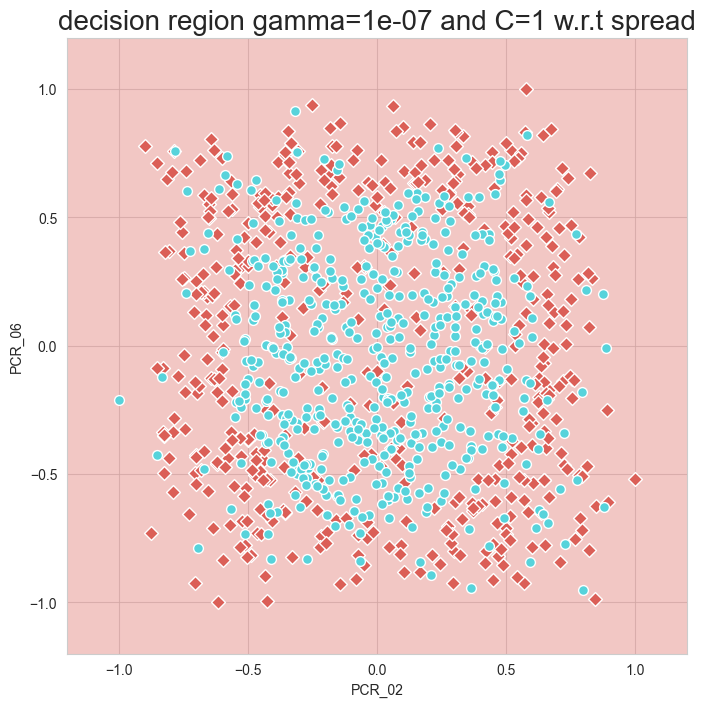

train accuracy: 0.512
test accuracy: 0.488


In [15]:
train_svc(1, 1e-7)

#### (Q15)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


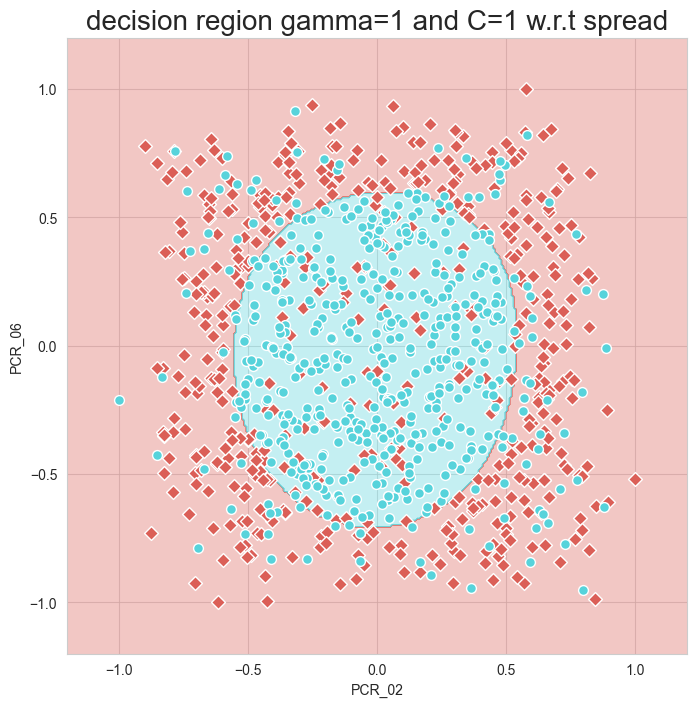

train accuracy: 0.795
test accuracy: 0.752


In [16]:
train_svc(1, 1)

#### (Q15)

C:\Dev\ML-02360766\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


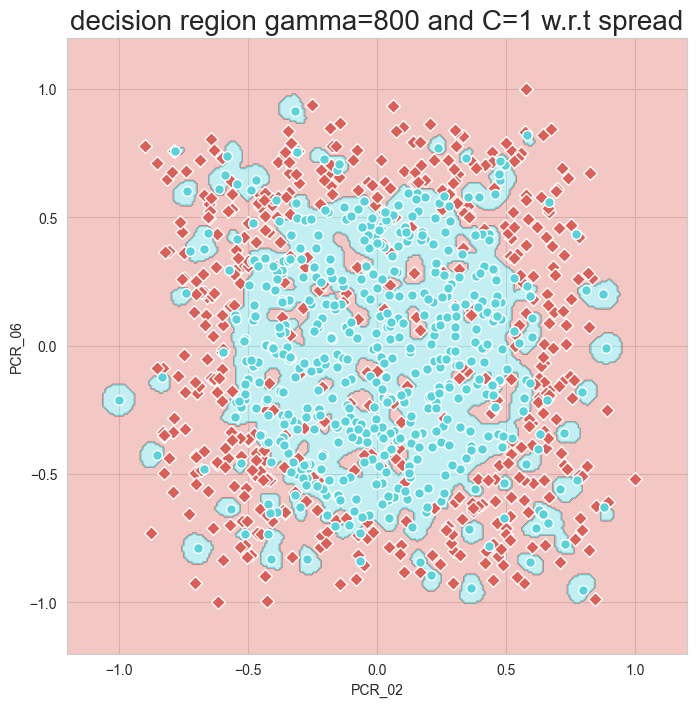

train accuracy: 0.946
test accuracy: 0.676


In [17]:
train_svc(1, 800)